# SHAPELETS LEARNING DEMO (univariate)

Demo for Beggel's ADSL algorithm implementation in pytorch 

In [1]:
import sys
sys.path.append('../')

import torch
from torch import tensor
from torch.optim.lr_scheduler import ExponentialLR, MultiplicativeLR

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.learning.learningextractor import LearningShapelets
from src.SVDD.SVDD import SVDD
from src.util import Scaler, get_weights_via_kmeans

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


/Users/test1/miniconda3/envs/SVDD/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up the dataset

### Load the data

Download the data (if needed):

In [2]:
# data_name = "GunPoint"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [3]:
data_name = "GunPoint"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [4]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

# if needed use label encoder to transform the labels from strings to integers
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# le.classes_

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (50, 150, 1)
Shape of test data: (150, 150, 1)
The different classes: {1, 2}
Shape of the total data: (200, 150, 1)
Number of total samples in each class: [100, 100]


Plot one sample per class:

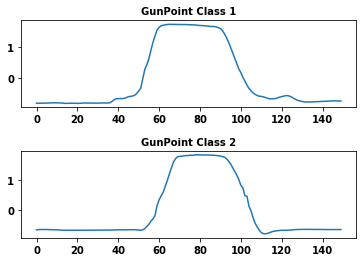

In [5]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# assume the labels start from 1 
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Create anomaly detection dataset:

In [6]:
# Set seed for determinism
np.random.seed(0)

# Set up anomaly detection dataset

alpha = 0.05 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=1)


Get statistics of the anomaly detection dataset:

In [7]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))

GunPoint dataset
number train ts is 84, each of length 150
They belong to two possible classes: {1, -1}
number test ts 116
number of normal train series: 80
number of normal test series: 20


#### Normalize:

In [8]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

In [9]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

#### Plot train and test set

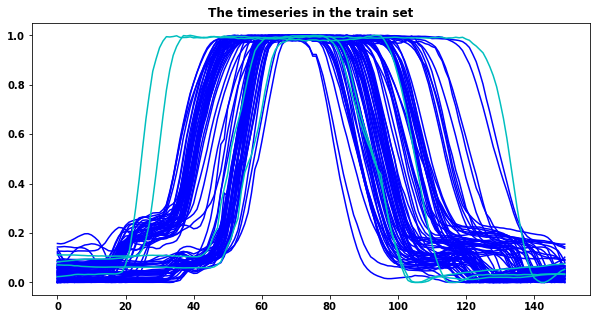

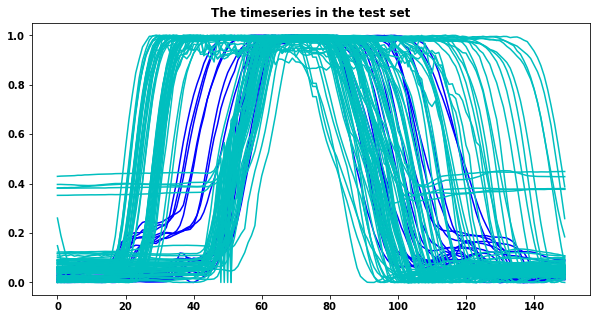

In [10]:
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly, y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly, y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Train the model:

Implementation of Beggel's "Anomaly Detection algorithm with Shapelet-based Feature Learning" (ADSL).
K Shapelets of length L are parametrized; given the shapelet transform of a multivariate time series $t^i$ with C channels:
\begin{equation}
x^i = (x^i_1, \dots, x^i_K), \enspace x^i_k = min_{l=1,\dots, J} \left\lVert s^k  - t^i_{l, l+L}\right\rVert^2
\end{equation}

Define $l(x^i) = \sum_{k=1}^K (x^i_k)^2$ the norm of the transform vector in $R^K$

Given a batch of N time series, the loss to minimize is:
\begin{equation}
L_S(t^1,\dots,t^N) = \frac{1}{N} (\sum_{i=1}^N max(0, l(x^i) - R^2) C +  \sum_{i=1}^N l(x^i))
\end{equation}
where R is the radius of the last update of the SVDD boundary, C is the hyperparameter of the SVDD.

#### Random Inizialization Training

In [11]:
K_star = 0.02
L_star = 0.2
L = round(L_star*Q)
K = round(K_star*Q)
C = 1 / (N * alpha)
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=1, to_cuda=False)
lr = 1e-2
optimizer = torch.optim.SGD(extractor.model.parameters(), lr=lr)
extractor.set_optimizer(optimizer)

n_epoch_steps = 40
n_epochs = 2
# total epochs = n_epoch_steps * n_epochs
batch_size = 4

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)

# compute the starting radius
extractor.compute_radius(X_train_tensor, tol=1e-8)

losses = []
for _ in range(n_epoch_steps):
    extractor.compute_radius(X_train_tensor)
    print('radius', extractor.loss_func.get_radius())
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

radius 11.256975


Loss: 10.728706359863281: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s]


radius 10.838672


Loss: 10.310262680053711: 100%|██████████| 2/2 [00:00<00:00, 24.89it/s]


radius 10.42023


Loss: 9.891948699951172: 100%|██████████| 2/2 [00:00<00:00, 19.28it/s]


radius 10.001916


Loss: 9.473770141601562: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s]


radius 9.583744


Loss: 9.05575942993164: 100%|██████████| 2/2 [00:00<00:00, 17.50it/s]


radius 9.165733


Loss: 8.637933731079102: 100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


radius 8.74791


Loss: 8.220277786254883: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


radius 8.330293


Loss: 7.802817344665527: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


radius 7.9129233


Loss: 7.385511875152588: 100%|██████████| 2/2 [00:00<00:00, 20.71it/s]


radius 7.49583


Loss: 6.9683942794799805: 100%|██████████| 2/2 [00:00<00:00, 24.12it/s]


radius 7.0790753


Loss: 6.551628112792969: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s]


radius 6.662729


Loss: 6.1352949142456055: 100%|██████████| 2/2 [00:00<00:00, 17.46it/s]


radius 6.211141


Loss: 5.719483375549316: 100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


radius 5.7793593


Loss: 5.304304599761963: 100%|██████████| 2/2 [00:00<00:00, 24.42it/s]


radius 5.363379


Loss: 4.889916896820068: 100%|██████████| 2/2 [00:00<00:00, 26.51it/s]


radius 4.9480762


Loss: 4.476551055908203: 100%|██████████| 2/2 [00:00<00:00, 24.40it/s]


radius 4.533634


Loss: 4.064495086669922: 100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


radius 4.1202917


Loss: 3.653956174850464: 100%|██████████| 2/2 [00:00<00:00, 19.04it/s]


radius 3.7708285


Loss: 3.2449967861175537: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s]


radius 3.3665125


Loss: 2.8391261100769043: 100%|██████████| 2/2 [00:00<00:00, 22.85it/s]


radius 2.9612343


Loss: 2.437821388244629: 100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


radius 2.5602903


Loss: 2.0435879230499268: 100%|██████████| 2/2 [00:00<00:00, 20.32it/s]


radius 2.1746242


Loss: 1.66103196144104: 100%|██████████| 2/2 [00:00<00:00, 23.79it/s]


radius 1.7992034


Loss: 1.2991901636123657: 100%|██████████| 2/2 [00:00<00:00, 25.56it/s]


radius 1.4476848


Loss: 0.9758010506629944: 100%|██████████| 2/2 [00:00<00:00, 27.50it/s]


radius 1.1396632


Loss: 0.7263146042823792: 100%|██████████| 2/2 [00:00<00:00, 26.58it/s]


radius 0.9074979


Loss: 0.5852929353713989: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s]


radius 0.77888185


Loss: 0.6132530570030212: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


radius 0.70075077


Loss: 0.6818480491638184: 100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


radius 0.66679525


Loss: 0.7117996215820312: 100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


radius 0.65135735


Loss: 0.7330322265625: 100%|██████████| 2/2 [00:00<00:00, 25.46it/s]


radius 0.6400327


Loss: 0.7424807548522949: 100%|██████████| 2/2 [00:00<00:00, 25.61it/s]


radius 0.63774997


Loss: 0.7459136247634888: 100%|██████████| 2/2 [00:00<00:00, 19.24it/s]


radius 0.6353982


Loss: 0.7494852542877197: 100%|██████████| 2/2 [00:00<00:00, 24.36it/s]


radius 0.6346423


Loss: 0.7500790357589722: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


radius 0.6365276


Loss: 0.7478280067443848: 100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


radius 0.6384937


Loss: 0.7477884292602539: 100%|██████████| 2/2 [00:00<00:00, 24.89it/s]


radius 0.63822687


Loss: 0.7448223829269409: 100%|██████████| 2/2 [00:00<00:00, 27.44it/s]


radius 0.6393625


Loss: 0.7393554449081421: 100%|██████████| 2/2 [00:00<00:00, 20.95it/s]


radius 0.63815844


Loss: 0.7388604879379272: 100%|██████████| 2/2 [00:00<00:00, 22.43it/s]


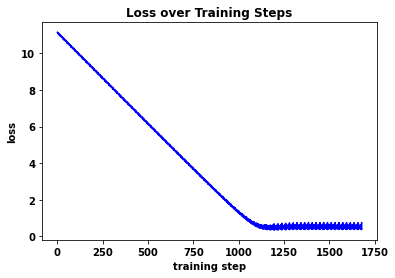

In [12]:
# plot loss decay
plt.plot(losses, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()

Type and shape of the shapelets in output <class 'numpy.ndarray'> (3, 30, 1)


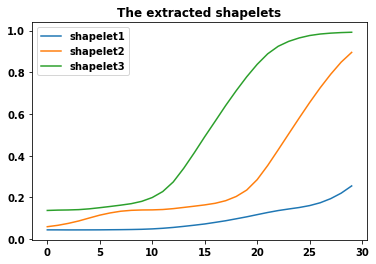

In [13]:
# plot the shapelets
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)
print('Type and shape of the shapelets in output', type(S),  S.shape)

plt.figure()
for i in range(len(S)):
    shap = S[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()


#### Initialize the shapelets' parameters using KMeans:

Auxiliary functions:

Set up the hyperparameters (length and number of shapelets) and shapelets' parameters:

In [28]:
K_star = 0.02
L_star = 0.2
L = round(L_star*Q)
K = round(K_star*Q)
clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
# set_shapelet_weights needs input of shape (num_shapelets, in_channels, len_shapelets)
clusters_centers = clusters_centers.transpose(0,2,1)
print(f'The shape of cluster centers is {clusters_centers.shape}')

The shape of cluster centers is (3, 1, 30)


In [29]:
C = 1 / (N * alpha)
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=1, to_cuda=False)
extractor.set_shapelet_weights(clusters_centers)

Set the optimzer:

In [30]:
lr = 1e-3
optimizer = torch.optim.SGD(extractor.model.parameters(), lr=lr)
lmbda = lambda epoch : 0.1
# scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
extractor.set_optimizer(optimizer)
# extractor.set_scheduler(scheduler)

Train the model and plot the shapelets:

In [31]:
n_epoch_steps = 40
n_epochs = 2
# total epochs = n_epoch_steps * n_epochs
batch_size = 4

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2)

extractor.compute_radius(X_train_tensor, tol=1e-8)

losses = []
for _ in range(n_epoch_steps):
    extractor.compute_radius(X_train_tensor)
    print('radius', extractor.loss_func.get_radius())
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

radius 0.8953288


Loss: 0.9619556069374084: 100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


radius 0.85538244


Loss: 0.9634592533111572: 100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


radius 0.8267425


Loss: 0.9515765905380249: 100%|██████████| 2/2 [00:00<00:00, 27.25it/s]


radius 0.79883915


Loss: 0.9408681392669678: 100%|██████████| 2/2 [00:00<00:00, 26.21it/s]


radius 0.7722062


Loss: 0.9310523867607117: 100%|██████████| 2/2 [00:00<00:00, 24.99it/s]


radius 0.745801


Loss: 0.921483039855957: 100%|██████████| 2/2 [00:00<00:00, 27.07it/s]


radius 0.7214211


Loss: 0.9169307947158813: 100%|██████████| 2/2 [00:00<00:00, 27.65it/s]


radius 0.71697104


Loss: 0.8907044529914856: 100%|██████████| 2/2 [00:00<00:00, 25.69it/s]


radius 0.68172306


Loss: 0.9103177189826965: 100%|██████████| 2/2 [00:00<00:00, 25.82it/s]


radius 0.6656181


Loss: 0.9080495834350586: 100%|██████████| 2/2 [00:00<00:00, 24.75it/s]


radius 0.65250397


Loss: 0.9056777954101562: 100%|██████████| 2/2 [00:00<00:00, 24.54it/s]


radius 0.6415778


Loss: 0.9051458835601807: 100%|██████████| 2/2 [00:00<00:00, 22.43it/s]


radius 0.63342726


Loss: 0.9034502506256104: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]


radius 0.6266393


Loss: 0.9020259976387024: 100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


radius 0.6210065


Loss: 0.901161253452301: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


radius 0.6301449


Loss: 0.8853757381439209: 100%|██████████| 2/2 [00:00<00:00, 18.61it/s]


radius 0.6325914


Loss: 0.8790638446807861: 100%|██████████| 2/2 [00:00<00:00, 24.12it/s]


radius 0.63475555


Loss: 0.8735489845275879: 100%|██████████| 2/2 [00:00<00:00, 11.01it/s]


radius 0.6368983


Loss: 0.8696082830429077: 100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


radius 0.63849807


Loss: 0.8667834997177124: 100%|██████████| 2/2 [00:00<00:00, 25.65it/s]


radius 0.63999546


Loss: 0.8640061616897583: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


radius 0.64168227


Loss: 0.8610796928405762: 100%|██████████| 2/2 [00:00<00:00, 21.09it/s]


radius 0.64324063


Loss: 0.8587632775306702: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s]


radius 0.64450514


Loss: 0.8567872047424316: 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]


radius 0.6457499


Loss: 0.8548063039779663: 100%|██████████| 2/2 [00:00<00:00, 22.16it/s]


radius 0.64702207


Loss: 0.853022575378418: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


radius 0.64819664


Loss: 0.8515880107879639: 100%|██████████| 2/2 [00:00<00:00, 14.59it/s]


radius 0.649215


Loss: 0.8500019311904907: 100%|██████████| 2/2 [00:00<00:00, 24.34it/s]


radius 0.65028733


Loss: 0.8480920791625977: 100%|██████████| 2/2 [00:00<00:00, 25.59it/s]


radius 0.65154505


Loss: 0.8460274934768677: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]


radius 0.6526423


Loss: 0.8440443277359009: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]


radius 0.6537733


Loss: 0.8418127298355103: 100%|██████████| 2/2 [00:00<00:00, 25.33it/s]


radius 0.6550168


Loss: 0.8389731645584106: 100%|██████████| 2/2 [00:00<00:00, 25.61it/s]


radius 0.6563585


Loss: 0.835451066493988: 100%|██████████| 2/2 [00:00<00:00, 25.55it/s]


radius 0.65799755


Loss: 0.83132004737854: 100%|██████████| 2/2 [00:00<00:00, 23.27it/s]


radius 0.6599222


Loss: 0.8269761800765991: 100%|██████████| 2/2 [00:00<00:00, 27.34it/s]


radius 0.66163605


Loss: 0.8225927352905273: 100%|██████████| 2/2 [00:00<00:00, 18.27it/s]


radius 0.66332185


Loss: 0.8182994723320007: 100%|██████████| 2/2 [00:00<00:00, 26.47it/s]


radius 0.7425018


Loss: 0.7224594354629517: 100%|██████████| 2/2 [00:00<00:00, 24.40it/s]


radius 0.6664305


Loss: 0.8100934028625488: 100%|██████████| 2/2 [00:00<00:00, 26.36it/s]


Plot the loss decay:

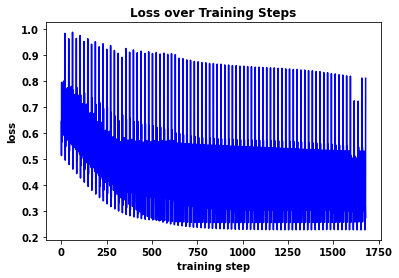

In [32]:
plt.plot(losses, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()

Get the shapelets and plot them:

Type and shape of the shapelets in output <class 'numpy.ndarray'> (3, 30, 1)


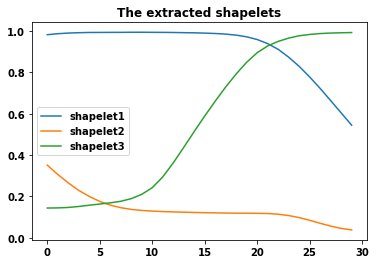

In [33]:
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)
print('Type and shape of the shapelets in output', type(S),  S.shape)

plt.figure()
for i in range(len(S)):
    shap = S[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

Transform train and test set:

In [34]:
# tranform method takes in input a tensor of shape (n_samples, in_channels, len_ts) 
# and outputs a numpy array of shape (n_samples, n_shapelets)
X_train_transform = extractor.transform(X_train_tensor)

X_test_tensor = tensor(X_test_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_test_transform = extractor.transform(X_test_tensor)

# check if type and shape are correct:
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (84, 3)
Type and shape of transformed test data <class 'numpy.ndarray'> (116, 3)


## Anomaly detection using SVDD

Choose how many extracted shapelets to take (2 for visualization purposes):

In [35]:
print('The maximum number of shapelets that can be taken is', K)
n_shap = K # n_shap must be <= K
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]
print(X_train_transform.shape)

The maximum number of shapelets that can be taken is 3
(84, 2)


Set up the parameter C in two ways:
1. using proportion of anomalies w.r.t. the total number of time series in the train set
2. using proportion of anomalies w.r.t. the number of normal time series in the train set (little bit higher, as in Beggel's paper)

This changes because the resulting C in 2. is a bit smaller, giving a tighter boundary.

The more C is small the more the boundary is tight.

OBSERVATION: often (as in GunPoint dataset) we prefer a tighter boundary because some normal observations may differ from the trend.

In [36]:
# nu is the proportion of anomalies w.r.t. the total
nu = np.around(len(y_train_anomaly[y_train_anomaly==-1])/len(y_train_anomaly), 3)
print(nu)

# set C with real percentage of anomalies
C1 = 1 / (N * nu)
print(C1)

# set C according to Beggel's paper (smaller)
C2 = 1 / (N * alpha)
print(C2)

0.048
0.24801587301587302
0.23809523809523808


In [37]:
svdd = SVDD(C=C2, zero_center=True)

# fit the model
svdd.fit(X_train_transform)

5 support vectors out of 84 points
Solution found with center in 0.0 and radius 0.5540285110473633


EVALUATE the prediction:

In [38]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = svdd.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("SVDD train balanced accuracy:", train_ba)

# AUC
y_train_scores = svdd.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("SVDD train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD train balanced accuracy: 0.60625
SVDD train AUC: 0.946875
SVDD train F1 score: 0.9625000000000001


In [39]:
## TEST
# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("SVDD test balanced accuracy:", test_ba)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("SVDD test AUC:", auc_test)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD test balanced accuracy: 0.6302083333333334
SVDD test AUC: 0.9973958333333334
SVDD train F1 score: 0.9625000000000001


### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in more than two dimension of the true points (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

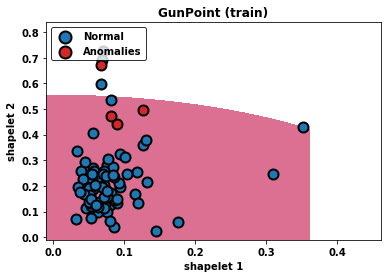

In [40]:
x_max = max(X_train_transform[:,0])+0.01
y_max = max(X_train_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

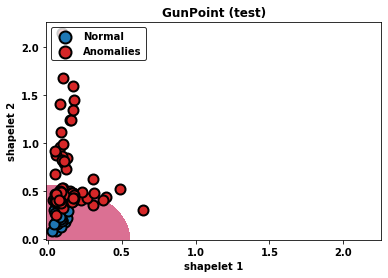

In [41]:
x_max = max(X_test_transform[:,0])+0.01
y_max = max(X_test_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()